In this notebook, I tried to compare anomaly detection of stock price with it is volume. 

First let's install necessary libraries

In [1]:
!pip install numpy
!pip install pandas
!pip install yfinance
!pip install torch  torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now we found a basic level anomaly detection model via autoencode written with pytorch

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf


def detect_anomalies_with_autoencoder(series, window_size=20, latent_dim=3, epochs=100):
    # Prepare the input data
    X = []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size].values)
    X = np.array(X)
    X = torch.from_numpy(X).float()
    
    # Define the autoencoder architecture
    model = Autoencoder(window_size, latent_dim)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the autoencoder
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
    
    # Use the trained autoencoder to detect anomalies
    X_pred = model(X)
    mse = torch.mean(torch.pow(X - X_pred, 2), dim=1).detach().numpy()
    threshold = np.percentile(mse, 95)
    anomalies = series.iloc[window_size:][mse >= threshold]
    
    return anomalies

class Autoencoder(nn.Module):
    def __init__(self, window_size, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(window_size, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, window_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

I will use yfinance to get stock data. I will use 1 minute intraday data since there is more action there. 

Now I will first define Window size and latent dim. I will draw both close and volume values to compare if it is captured same time.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
def plot_anomalies(symbol,window_size = 30 ):
  stock = yf.download(symbol, interval='1m')
  stock.index = pd.to_datetime(stock.index).strftime("%d-%m-%Y %H:%M:%S")

  # Detect anomalies using Autoencoder on Adj Close data
  window_size = 30
  latent_dim = 3
  adj_close_anomalies = detect_anomalies_with_autoencoder(stock['Adj Close'], window_size, latent_dim)

  # Detect anomalies using Autoencoder on Volume data
  volume_anomalies = detect_anomalies_with_autoencoder(stock['Volume'], window_size, latent_dim)

  # Create subplots
  fig, ax1 = plt.subplots(figsize=(14, 10))

  # Plot Adj Close data on the right axis
  ax1.plot(stock.index, stock['Adj Close'], color='blue', label='Adj Close')
  ax1.scatter(adj_close_anomalies.index, adj_close_anomalies.values, color='red', label='Adj Close Anomalies')
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Price')
  ax1.tick_params(axis='y')
  ax1.legend(loc='upper left')

  # Create left axis for Volume data
  ax2 = ax1.twinx()

  # Plot Volume data on the left axis
  ax2.plot(stock.index, stock['Volume'], color='green', label='Volume')
  ax2.scatter(volume_anomalies.index, volume_anomalies.values, color='orange', label='Volume Anomalies')
  ax2.set_ylabel('Volume')
  ax2.tick_params(axis='y')
  ax2.legend(loc='upper right')

  # Set titles and grid
  plt.title(f'Stock Adj Close and Volume Anomaly Detection - Autoencoder for {symbol}')
  plt.grid(True)

  # Show the plot
  plt.show()


[*********************100%***********************]  1 of 1 completed


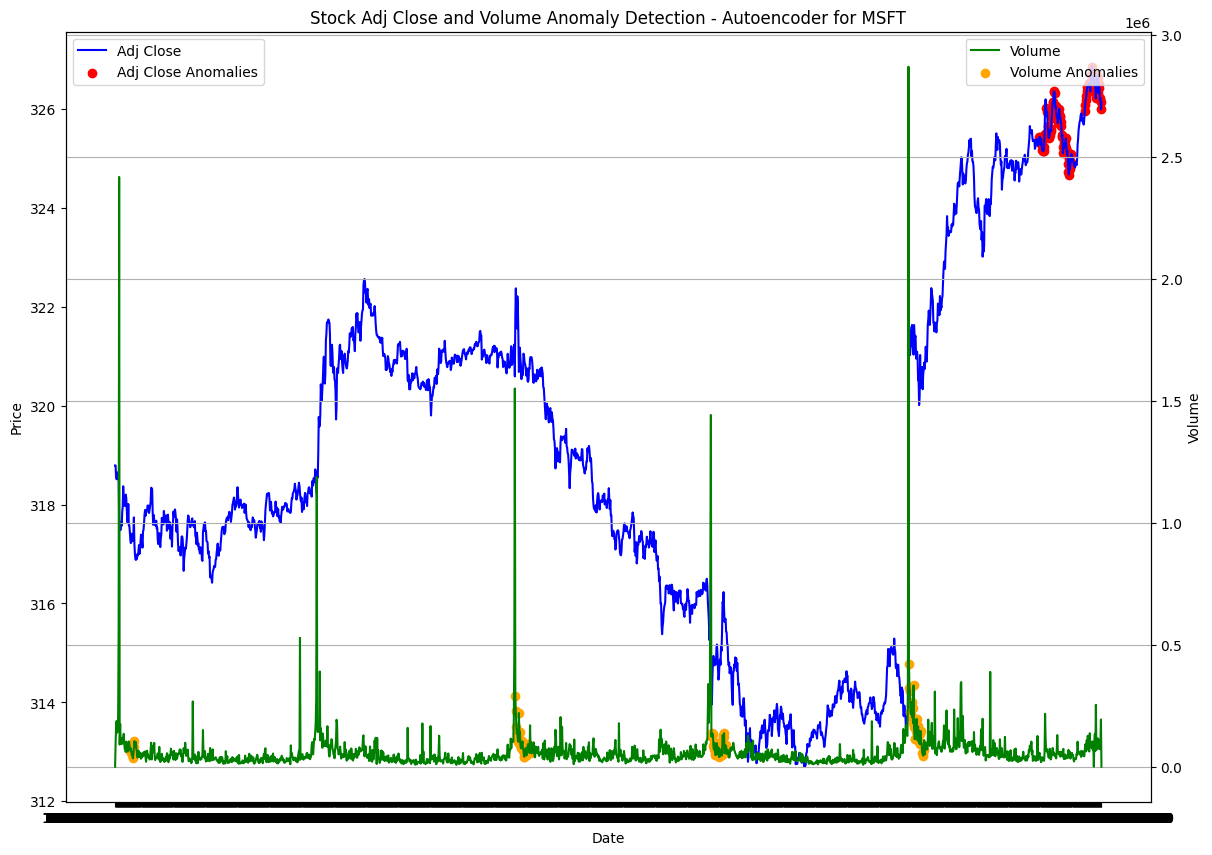

In [22]:
plot_anomalies("MSFT")

[*********************100%***********************]  1 of 1 completed


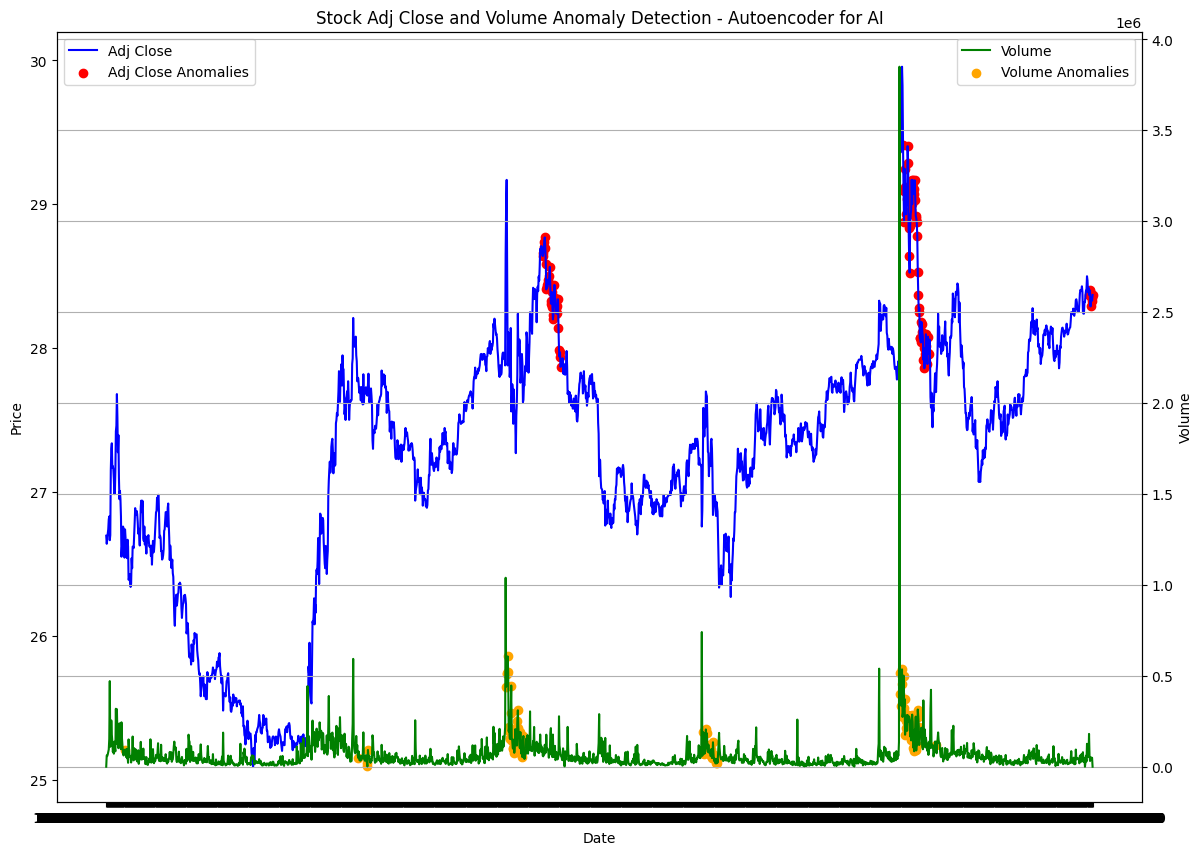

In [23]:
plot_anomalies("AI")

Above we see that market openings create an anomaly for volume while sharpe moves of close price create anomlies.

[*********************100%***********************]  1 of 1 completed


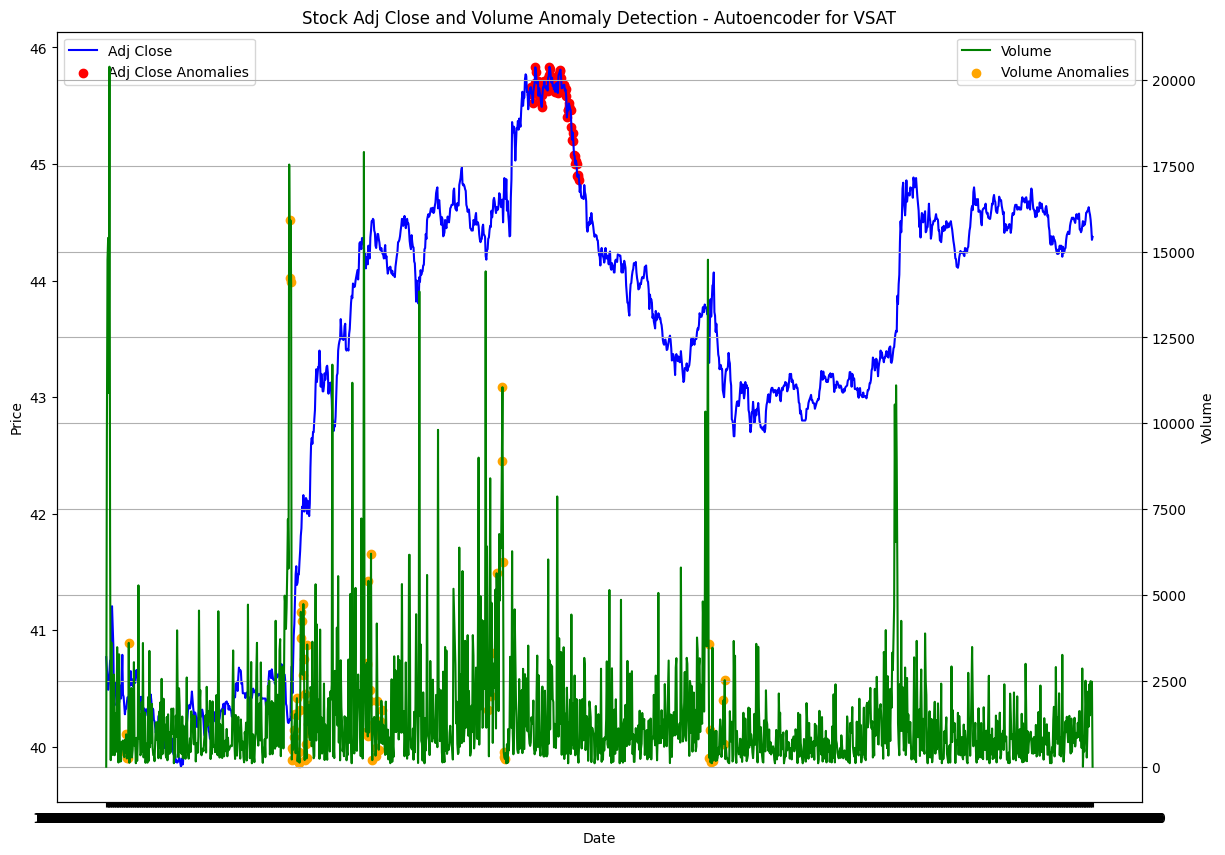

In [24]:
plot_anomalies("VSAT")

[*********************100%***********************]  1 of 1 completed


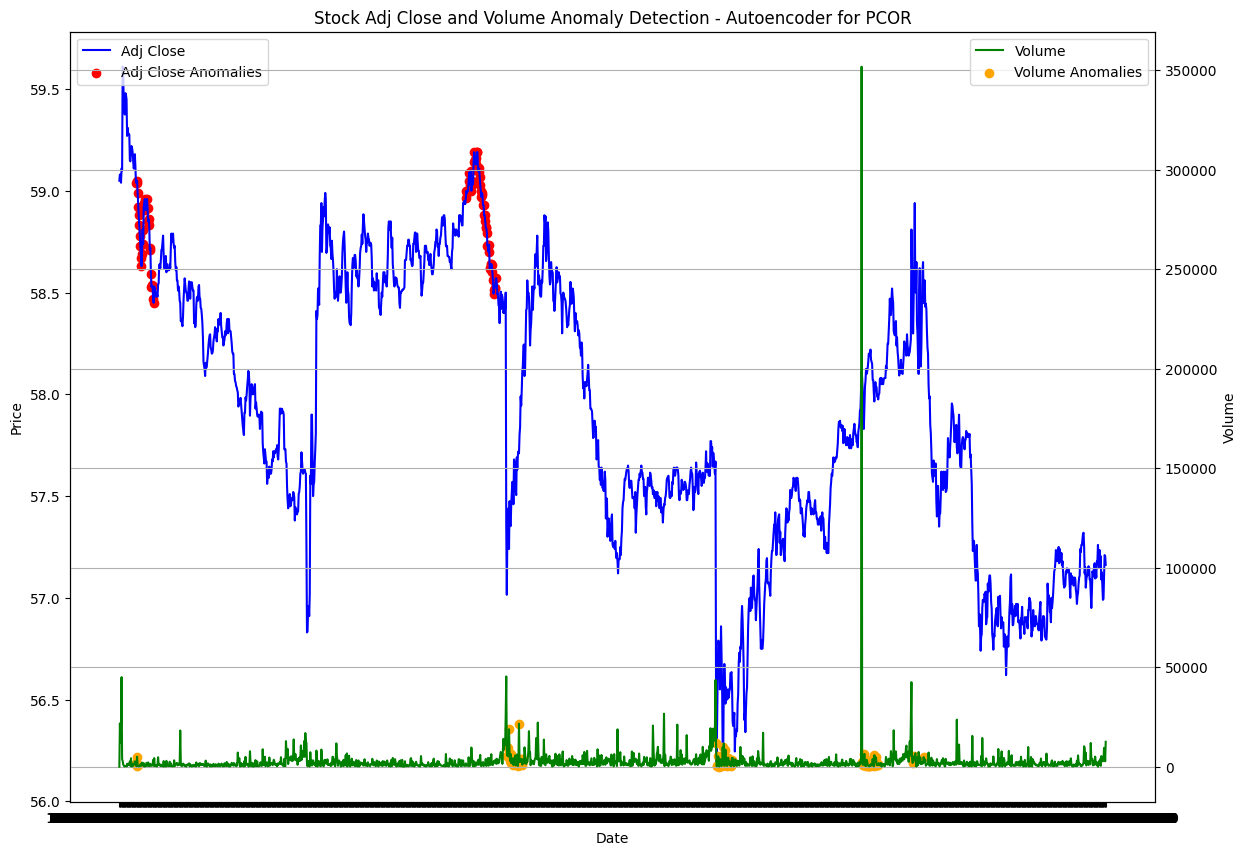

In [25]:
plot_anomalies("PCOR")